# Make color-prior object dataset
This notebook creates a dataset of real-world objects with **known color priors**.
Images are obtained through targeted queries in *query_google_images.ipynb* and segmented to produce binary foreground masks using *segment_outline.ipynb*.
Using these masks, foreground and background regions are colored independently, enabling controlled manipulations of object color while preserving object identity.
Recoloring is implemented via *recolor_images.py*.
Color priors are model-specific and can be queried using *model_priors.py*.

In [1]:
%reload_ext autoreload
%autoreload 2

from transformers import (
    BitsAndBytesConfig,
    LlavaNextProcessor,
    LlavaNextForConditionalGeneration
)
import torch
import pandas as pd
import re
import gc
import numpy as np
from tqdm import tqdm
import os
import re
import sys
from pathlib import Path
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

ROOT = Path().resolve().parents[0]
sys.path.insert(0, str(ROOT))

from model_evaluation.test_MLLMs import run_vlm_evaluation
from making_color_images.model_priors import TorchColorPriors, GPTColorPriors
from making_color_images.plot_variants import collect_variants_for, show_variants_grid, plot_vlm_performance, variant_label
from making_color_images.recolor_images import generate_variants, resize_all_images_and_masks


os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

fontsize = 14

In [2]:
# Set a specific seed for reproducibility
SEED = 42
rng = np.random.default_rng(SEED)

# Setting the seed for PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # If using GPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    llm_int8_enable_fp32_cpu_offload=True
)

torch.cuda.empty_cache()
gc.collect()

Using device: cuda


76

In [3]:
# Base data folder
WORK = Path(os.environ.get("WORK", Path.cwd()))
DATA = WORK / "color-concept-entanglement" / "data"

FRUIT = DATA / "fruit"
OUTLINES = DATA / "color_images"

RESIZED_IMGS = DATA / "resized_images"
RESIZED_MASKS = DATA / "resized_cv_masks"
RESIZED_IMGS.mkdir(parents=True, exist_ok=True)
RESIZED_MASKS.mkdir(parents=True, exist_ok=True)

In [6]:
# Define the percentage grid for coloring
pct_schedule = list(range(0, 11, 1)) + list(range(20, 60, 10)) + list([55]) + list(range(60, 110, 10))
print("Percentage grid:", pct_schedule)

Percentage grid: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 55, 60, 70, 80, 90, 100]


## 1. LLaVA-NeXT

### 1.1. Load model and base dataframe

In [10]:
model_name = "llava-v1.6-mistral-7b-hf"
processor = LlavaNextProcessor.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf")
model = LlavaNextForConditionalGeneration.from_pretrained(
    "llava-hf/llava-v1.6-mistral-7b-hf", dtype=torch.float16, low_cpu_mem_usage=True, device_map="auto", quantization_config=bnb_config
).to(device)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [11]:
# Load dataframe with outline images and masks
df = pd.read_csv(DATA / "segmented_images.csv")
display(df)

,correct_answer,incorrect_answer,object,image_url,image_path,gpt_response,score,watermark,num_objects,cv_mask_path,sam_mask_path
0,['yellow'],purple,sunflower,https://thumbs.dreamstime.com/b/black-outline-...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
1,"['brown', 'black', 'orange']",green,tabby,https://img.recraft.ai/5P-WlUIGI2MwJC2v_JyrGkp...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
2,"['pink', 'white']",green,spoonbill,https://img.freepik.com/premium-vector/drawing...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
3,['white'],green,Samoyed,https://img.freepik.com/premium-photo/black-wh...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
4,"['grey', 'black']",red,Norwegian elkhound,https://t3.ftcdn.net/jpg/16/85/30/00/360_F_168...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
...,...,...,...,...,...,...,...,...,...,...,...
215,"['gold', 'silver']",green,crown,https://i.pinimg.com/736x/32/52/35/325235d85fb...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",42.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
216,"['orange', 'white']",purple,pill bottle,https://media.istockphoto.com/id/470313936/vec...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",35.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
217,['black'],pink,dial telephone,https://png.pngtree.com/png-clipart/20230811/o...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",35.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
218,['black'],pink,digital watch,https://img.freepik.com/premium-vector/digital...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",34.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...


### 1.2. Get model-specific color priors

In [12]:
# Initalize ModelColorPriors
priors = TorchColorPriors(
    processor=processor,
    model=model,
    data_folder=DATA,
    device=device
)

In [ ]:
# Generate new priors
# priors_df = priors.get_model_color_priors(df, save=True)

In [13]:
# Checkpoint: display the generated priors
priors_df = priors.load_model_priors()
display(priors_df[['object', 'correct_answer', 'dummy_priors', 'image_priors']])

,object,correct_answer,dummy_priors,image_priors
0,sunflower,[yellow],"[yellow, brown, green]","[yellow, black, white]"
1,tabby,"[brown, black, orange]","[black, grey, white]","[black, grey, white]"
2,spoonbill,"[pink, white]","[pink, white, black]","[white, black, grey]"
3,Samoyed,[white],"[white, cream, light brown]","[white, cream, light grey]"
4,Norwegian elkhound,"[grey, black]","[grey, black, brown]","[white, grey, black]"
...,...,...,...,...
215,crown,"[gold, silver]","[gold, silver, white]","[gold, silver, black]"
216,pill bottle,"[orange, white]","[blue, white, green]","[white, blue, green]"
217,dial telephone,[black],"[black, white, grey]","[black, white, grey]"
218,digital watch,[black],"[black, grey, blue]","[black, silver, white]"


In [14]:
# Pick a primary color prior, overwrite correct_answer, and drop all rows where the prior is None
DUMMY = False  # Set to True to use dummy priors, False for image priors
suffix = "dummy_priors" if DUMMY else "image_priors"
priors_df["prior"], priors_df["prior_changed"] = priors.pick_primary_color(priors_df, column=suffix)

[INFO] tabby: replaced 'black' with 'grey'
[INFO] spoonbill: replaced 'white' with 'grey'
[NULL] Samoyed: all priors invalid ['white', 'cream', 'light grey'] to NaN
[INFO] Norwegian elkhound: replaced 'white' with 'grey'
[INFO] hare: replaced 'white' with 'grey'
[NULL] car wheel: all priors invalid ['black', 'silver', 'white'] to NaN
[INFO] dandelion: replaced 'white' with 'yellow'
[INFO] bat_(animal): replaced 'black' with 'grey'
[INFO] buffalo: replaced 'black' with 'grey'
[INFO] ground beetle: replaced 'black' with 'brown'
[INFO] miniature pinscher: replaced 'white' with 'brown'
[INFO] oriole: replaced 'black' with 'grey'
[INFO] wombat: replaced 'black' with 'grey'
[INFO] tiger: replaced 'black' with 'orange'
[INFO] Chesapeake Bay retriever: replaced 'black' with 'brown'
[INFO] gorilla: replaced 'black' with 'brown'
[INFO] golf ball: replaced 'white' with 'yellow'
[INFO] spotted salamander: replaced 'black' with 'brown'
[INFO] american football: replaced 'white' with 'brown'
[NULL] 

In [15]:
print(f"Number of objects with valid model color priors: {len(priors_df['prior'].dropna())}")
print(f"Number of objects where the original prior was changed to be valid: {priors_df['prior_changed'].sum()}")
df["correct_answer"] = priors_df["prior"]

df.dropna(subset=["correct_answer"], axis=0, inplace=True)

#priors.analyze_differences(priors_df)
display(df)
df["correct_answer"].value_counts()

Number of objects with valid model color priors: 196
Number of objects where the original prior was changed to be valid: 146


,correct_answer,incorrect_answer,object,image_url,image_path,gpt_response,score,watermark,num_objects,cv_mask_path,sam_mask_path
0,yellow,purple,sunflower,https://thumbs.dreamstime.com/b/black-outline-...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
1,grey,green,tabby,https://img.recraft.ai/5P-WlUIGI2MwJC2v_JyrGkp...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
2,grey,green,spoonbill,https://img.freepik.com/premium-vector/drawing...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
4,grey,red,Norwegian elkhound,https://t3.ftcdn.net/jpg/16/85/30/00/360_F_168...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
5,red,yellow,lobster,https://media.istockphoto.com/id/848729864/vec...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
...,...,...,...,...,...,...,...,...,...,...,...
213,grey,yellow,cloud,https://i.pinimg.com/736x/82/89/8a/82898af848f...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",42.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
214,red,blue,apple,https://i.pinimg.com/736x/48/39/63/48396351091...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",42.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
216,blue,purple,pill bottle,https://media.istockphoto.com/id/470313936/vec...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",35.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
217,grey,pink,dial telephone,https://png.pngtree.com/png-clipart/20230811/o...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",35.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...


correct_answer
grey      59
brown     48
red       26
green     26
yellow    16
orange    12
blue       7
pink       1
purple     1
Name: count, dtype: int64

### 1.3. Color black-and-white base images with color prior

In [16]:
df = resize_all_images_and_masks(
    df,
    img_out_folder=RESIZED_IMGS,
    mask_out_folder=RESIZED_MASKS,
    target_size=512,              # or 256, 384, 1024
    mask_column="cv_mask_path",   
    img_column="image_path"
)


Resizing all: 100%|██████████| 196/196 [00:10<00:00, 19.27it/s]

Resized 196 images.


In [17]:
# Set coloring modes
coloring_modes = ["sequential"] #, "independent"]

OUT_COLOR = OUTLINES / model_name / suffix
OUT_COLOR.mkdir(parents=True, exist_ok=True)
print("Output folder for colored images:", OUT_COLOR)

Output folder for colored images: /mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/data/color_images/llava-v1.6-mistral-7b-hf/image_priors


In [ ]:
# Generate variants for all images in df
for _, row in tqdm(df.iterrows(), total=len(df), desc="Generating color variants"):
    for color_mode in coloring_modes:
        paths = generate_variants(
            row=row,
            target_color=row['correct_answer'],
            out_dir=OUT_COLOR,
            rng=rng,
            use_patches=True,
            patch_size=16,
            step_size=10,
            mode=color_mode,
            pct_schedule=pct_schedule
        )

In [ ]:
# Define which range of image variants to plot
tail_range = list(range(0, 6)) + list(range(95, 101))
ten_increase = list(range(0, 110, 10))
compact = [0, 10, 50, 90, 100]

In [ ]:
for idx, row in df.head(5).iterrows():
    for color_mode in coloring_modes:
        show_variants_grid(row['image_path'], row['correct_answer'], OUT_COLOR, color_mode=color_mode, pct_range=ten_increase)

## 2. GPT-4o

### 2.1. Load model and base dataframe

In [5]:
# Load segmented images dataframe again for GPT
df_GPT = pd.read_csv(DATA / "segmented_images.csv")
display(df_GPT)

,correct_answer,incorrect_answer,object,image_url,image_path,gpt_response,score,watermark,num_objects,cv_mask_path,sam_mask_path
0,['yellow'],purple,sunflower,https://thumbs.dreamstime.com/b/black-outline-...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
1,"['brown', 'black', 'orange']",green,tabby,https://img.recraft.ai/5P-WlUIGI2MwJC2v_JyrGkp...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
2,"['pink', 'white']",green,spoonbill,https://img.freepik.com/premium-vector/drawing...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
3,['white'],green,Samoyed,https://img.freepik.com/premium-photo/black-wh...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
4,"['grey', 'black']",red,Norwegian elkhound,https://t3.ftcdn.net/jpg/16/85/30/00/360_F_168...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",47.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
...,...,...,...,...,...,...,...,...,...,...,...
215,"['gold', 'silver']",green,crown,https://i.pinimg.com/736x/32/52/35/325235d85fb...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",42.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
216,"['orange', 'white']",purple,pill bottle,https://media.istockphoto.com/id/470313936/vec...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",35.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
217,['black'],pink,dial telephone,https://png.pngtree.com/png-clipart/20230811/o...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",35.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...
218,['black'],pink,digital watch,https://img.freepik.com/premium-vector/digital...,/mnt/lustre/work/eickhoff/esx061/color-concept...,"{'white_background': 'yes', 'style': 'illustra...",34.0,False,1.0,/mnt/lustre/work/eickhoff/esx061/color-concept...,/mnt/lustre/work/eickhoff/esx061/color-concept...


### 2.2. Get model-specific color priors

In [6]:
# Initialize GPTColorPriors
model_name = "gpt-4o"
priors_GPT = GPTColorPriors(model_name=model_name, data_folder=DATA)

# Generate GPT color priors
#priors_df_GPT = priors_GPT.get_model_color_priors(df_GPT, save=True)

# Load previously generated GPT priors
priors_df_GPT = priors_GPT.load_model_priors()

display(priors_df_GPT)

,object,correct_answer,dummy_priors,image_priors
0,sunflower,[yellow],"[yellow, brown, green]","[yellow, brown, green]"
1,tabby,"[brown, black, orange]","[brown, grey, orange]","[orange, grey, brown]"
2,spoonbill,"[pink, white]","[white, pink, black]","[white, black, grey]"
3,Samoyed,[white],"[white, cream, biscuit]","[white, cream, light grey]"
4,Norwegian elkhound,"[grey, black]","[grey, black, white]","[white, grey, black]"
...,...,...,...,...
215,crown,"[gold, silver]","[gold, silver, bronze]","[gold, silver, bronze]"
216,pill bottle,"[orange, white]","[orange, white, brown]","[brown, white, orange]"
217,dial telephone,[black],"[black, beige, red]","[black, red, beige]"
218,digital watch,[black],"[black, silver, blue]","[silver, black, blue]"


In [7]:
# Create a color prior table with one primary color per object using the IMAGE prompts
DUMMY_GPT = False
suffix = "dummy_priors" if DUMMY_GPT else "image_priors"
priors_df_GPT["prior"], priors_df_GPT["prior_changed"] = priors_GPT.pick_primary_color(priors_df_GPT, column=suffix)

[INFO] spoonbill: replaced 'white' with 'grey'
[NULL] Samoyed: all priors invalid ['white', 'cream', 'light grey'] to NaN
[INFO] Norwegian elkhound: replaced 'white' with 'grey'
[INFO] hare: replaced 'white' with 'grey'
[INFO] car wheel: replaced 'silver' with 'grey'
[INFO] dandelion: replaced 'white' with 'green'
[INFO] bat_(animal): replaced 'black' with 'brown'
[INFO] ground beetle: replaced 'black' with 'brown'
[NULL] miniature pinscher: all priors invalid ['tan', 'black', 'white'] to NaN
[INFO] Chesapeake Bay retriever: replaced 'black' with 'brown'
[INFO] gorilla: replaced 'black' with 'grey'
[INFO] giraffe: replaced 'tan' with 'brown'
[INFO] golf ball: replaced 'white' with 'yellow'
[NULL] French horn: all priors invalid ['gold', 'silver', 'brass'] to NaN
[NULL] washer: all priors invalid ['white', 'silver', 'black'] to NaN
[NULL] thimble: all priors invalid ['silver', 'gold', 'bronze'] to NaN
[NULL] bathtub: all priors invalid ['white', 'cream', 'light blue'] to NaN
[INFO] scre

In [8]:
print(f"Number of objects with valid model color priors: {len(priors_df_GPT['prior'].dropna())}")
print(f"Number of objects where the original prior was changed to be valid: {priors_df_GPT['prior_changed'].sum()}")
df_GPT["correct_answer"] = priors_df_GPT["prior"]

df_GPT.dropna(subset=["correct_answer"], axis=0, inplace=True)

#priors.analyze_differences(priors_df)
display(priors_df_GPT.dropna())
df_GPT["correct_answer"].value_counts()

Number of objects with valid model color priors: 199
Number of objects where the original prior was changed to be valid: 83


,object,correct_answer,dummy_priors,image_priors,prior,prior_changed
0,sunflower,[yellow],"[yellow, brown, green]","[yellow, brown, green]",yellow,False
1,tabby,"[brown, black, orange]","[brown, grey, orange]","[orange, grey, brown]",orange,False
2,spoonbill,"[pink, white]","[white, pink, black]","[white, black, grey]",grey,True
4,Norwegian elkhound,"[grey, black]","[grey, black, white]","[white, grey, black]",grey,True
5,lobster,[red],"[red, blue, yellow]","[red, brown, blue]",red,False
...,...,...,...,...,...,...
214,apple,"[red, green, yellow]","[red, green, yellow]","[red, green, yellow]",red,False
216,pill bottle,"[orange, white]","[orange, white, brown]","[brown, white, orange]",brown,False
217,dial telephone,[black],"[black, beige, red]","[black, red, beige]",red,True
218,digital watch,[black],"[black, silver, blue]","[silver, black, blue]",blue,True


correct_answer
brown     71
green     28
grey      28
red       27
blue      14
orange    13
yellow    11
pink       4
purple     3
Name: count, dtype: int64

In [9]:
# save filtered dataframe with GPT priors
name = f"color_priors_gpt-4o_{suffix}"
priors_df_GPT.to_csv(DATA / f"{name}.csv", index=False)

In [18]:
# Compare GPT vs Torch priors
torch_df = priors_df[["object", "prior"]].dropna().rename(columns={"prior": "prior_torch"})
gpt_df = priors_df_GPT[["object", "prior"]].dropna().rename(columns={"prior": "prior_gpt"})
valid_torch = torch_df.shape[0]
valid_gpt   = gpt_df.shape[0]
print(f"Number of objects with valid Torch priors: {valid_torch}")
print(f"Number of objects with valid GPT priors: {valid_gpt}")

merged = torch_df.merge(gpt_df, on="object", how="outer")



both_valid = merged.dropna(subset=["prior_torch", "prior_gpt"])
agreement_rate = (both_valid["prior_torch"] == both_valid["prior_gpt"]).mean()

print(f"Agreement rate (only objects with two priors): {agreement_rate:.3f}")
print(f"Compared objects: {len(both_valid)}")

diff = both_valid[both_valid["prior_torch"] != both_valid["prior_gpt"]]
print("Number of disagreements:", len(diff))
display(diff)

NameError: name 'priors_df' is not defined

### 2.3. Color black-and-white base images with color prior

In [10]:
# Upadate df_GPT with resized images and masks
df_GPT = resize_all_images_and_masks(
    df_GPT,
    img_out_folder=RESIZED_IMGS,
    mask_out_folder=RESIZED_MASKS,
    target_size=512,              # or 256, 384, 1024
    mask_column="cv_mask_path",   
    img_column="image_path"
)

Resizing all:   0%|          | 0/199 [00:00<?, ?it/s]

Resizing all: 100%|██████████| 199/199 [00:11<00:00, 16.67it/s]

Resized 199 images.


In [11]:
# Generate variants for all images in GPT prior df
OUT_COLOR = OUTLINES / model_name / suffix
print(f"Saving to {OUT_COLOR}")
OUT_COLOR.mkdir(parents=True, exist_ok=True)

Saving to /mnt/lustre/work/eickhoff/esx061/color-concept-entanglement/data/color_images/gpt-4o/image_priors


In [29]:
for _, row in tqdm(df_GPT.iterrows(), total=len(df_GPT), desc="Generating color variants"):
        paths = generate_variants(
            row=row,
            target_color=row['correct_answer'],
            out_dir=OUT_COLOR,
            rng=rng,
            use_patches=True,
            patch_size=16,
            mode="sequential",
            pct_schedule=pct_schedule
        )

Generating color variants: 100%|██████████| 13/13 [01:41<00:00,  7.79s/it]


In [ ]:
for idx, row in df_GPT.head(5).iterrows():
    for color_mode in coloring_modes:
        show_variants_grid(row['image_path'], row['incorrect_answer'], OUT_COLOR, color_mode=color_mode, pct_range=ten_increase)

## Compute fraction of black pixels inside object mask

In [32]:
def compute_black_fraction(df):
    results = []

    for _, row in tqdm(df.iterrows(), total=len(df)):

        img = Image.open(row["image_path"]).convert("RGB")
        mask = Image.open(row["cv_mask_path"]).convert("L")

        img_np = np.array(img)
        mask_np = np.array(mask) > 127

        # Same logic as recoloring code
        gray = np.mean(img_np, axis=2) / 255.0
        outline = gray < 0.12

        # Only inside object mask
        black_in_object = outline & mask_np

        total_object_pixels = mask_np.sum()
        black_pixels = black_in_object.sum()

        frac = black_pixels / total_object_pixels if total_object_pixels > 0 else np.nan

        results.append(frac)

    df = df.copy()
    df["black_outline_fraction"] = results
    return df

fractions_df = compute_black_fraction(df_GPT)

100%|██████████| 199/199 [00:02<00:00, 85.00it/s]


,object,correct_answer,black_outline_fraction
191,pine,green,0.659289
93,flat-coated_retriever,brown,0.554199
19,chesapeake_bay_retriever,brown,0.535938
59,rooster,red,0.526923
185,monarch,orange,0.426361
...,...,...,...
47,sewing_machine,brown,0.000000
79,gun,brown,0.000000
121,shrimp,pink,0.000000
170,lime,orange,0.000000


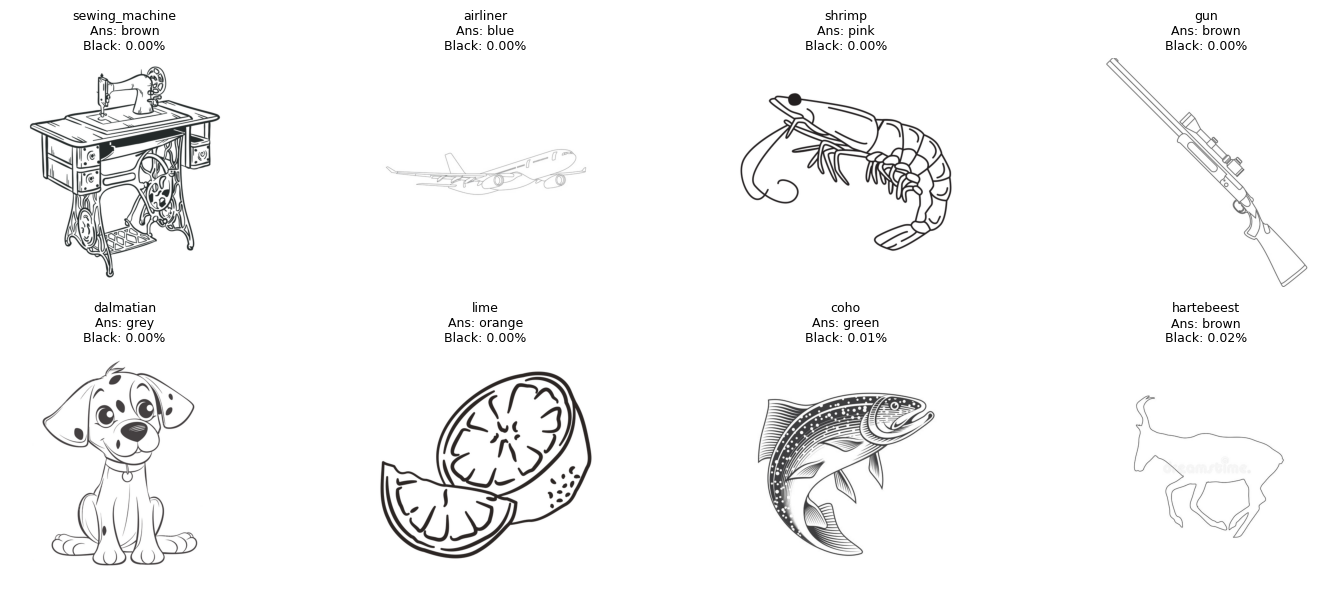

In [33]:
def show_top_fraction(df, n=8):
    
    df_sorted = df.sort_values(
        "black_outline_fraction",
        ascending=True
    ).head(n)
    
    plt.figure(figsize=(15, 6))
    
    for i, (_, row) in enumerate(df_sorted.iterrows()):
        plt.subplot(2, (n+1)//2, i+1)
        
        img = Image.open(row["image_path"])
        plt.imshow(img)
        plt.axis("off")
        
        title = (
            f'{row["object"]}\n'
            f'Ans: {row["correct_answer"]}\n'
            f'Black: {row["black_outline_fraction"]:.2%}'
        )
        plt.title(title, fontsize=9)
    
    plt.tight_layout()
    plt.show()

display(fractions_df[["object", "correct_answer", "black_outline_fraction"]].sort_values("black_outline_fraction", ascending=False))
show_top_fraction(fractions_df, n=8)

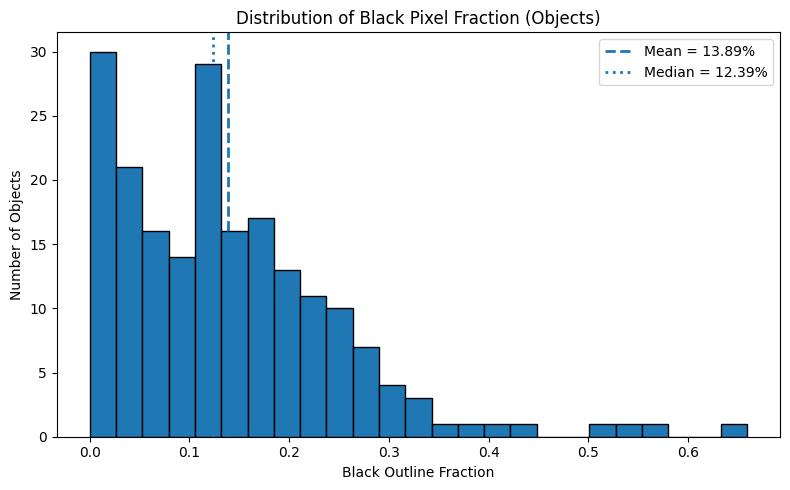

In [34]:
vals = fractions_df["black_outline_fraction"].dropna()

plt.figure(figsize=(8, 5))

plt.hist(vals, bins=25, edgecolor="black")

plt.axvline(vals.mean(), linestyle="--", linewidth=2, label=f"Mean = {vals.mean():.2%}")
plt.axvline(vals.median(), linestyle=":", linewidth=2, label=f"Median = {vals.median():.2%}")

plt.xlabel("Black Outline Fraction")
plt.ylabel("Number of Objects")
plt.title("Distribution of Black Pixel Fraction (Objects)")
plt.legend() 

plt.tight_layout()
plt.show()

## Compute fraction of changed pixels after coloring

In [15]:
# Load df with colored images
color_path = Path(DATA / "prolific_stimuli/stimulus_table_image_priors.csv")
df_color = pd.read_csv(color_path)
display(df_color)

,object,stimulus_type,manipulation_color,target_color,variant_region,percent_colored,mode,variant_label,image_path
0,Band Aid,correct_prior,pink,white,BG,0,seq,BG 0% (seq),color_images/gpt-4o/image_priors/Band_Aid_1_e7...
1,Band Aid,correct_prior,pink,white,BG,5,seq,BG 5% (seq),color_images/gpt-4o/image_priors/Band_Aid_1_e7...
2,Band Aid,correct_prior,pink,white,BG,10,seq,BG 10% (seq),color_images/gpt-4o/image_priors/Band_Aid_1_e7...
3,Band Aid,correct_prior,pink,white,BG,20,seq,BG 20% (seq),color_images/gpt-4o/image_priors/Band_Aid_1_e7...
4,Band Aid,correct_prior,pink,white,BG,30,seq,BG 30% (seq),color_images/gpt-4o/image_priors/Band_Aid_1_e7...
...,...,...,...,...,...,...,...,...,...
5169,worm,correct_prior,brown,brown,FG,60,seq,FG 60% (seq),color_images/gpt-4o/image_priors/worm_1_69c913...
5170,worm,correct_prior,brown,brown,FG,70,seq,FG 70% (seq),color_images/gpt-4o/image_priors/worm_1_69c913...
5171,worm,correct_prior,brown,brown,FG,80,seq,FG 80% (seq),color_images/gpt-4o/image_priors/worm_1_69c913...
5172,worm,correct_prior,brown,brown,FG,90,seq,FG 90% (seq),color_images/gpt-4o/image_priors/worm_1_69c913...


In [ ]:
def normalize_object_name(name: str) -> str:
    name = name.strip()
    name = name.lower()
    
    # replace spaces with underscores
    name = name.replace(" ", "_")
    
    return name

In [21]:
# Separate variants
df_0 = df_color[df_color["variant_label"] == "BG 0% (seq)"]
df_100 = df_color[df_color["variant_label"] == "FG 100% (seq)"]

# Merge 0% and 100% by object
df_compare = df_0.merge(
    df_100,
    on="object",
    suffixes=("_0", "_100")
)

df_compare["object"] = df_compare["object"].apply(normalize_object_name)
df_GPT["object"] = df_GPT["object"].apply(normalize_object_name)

# Add mask path from original df
df_compare = df_compare.merge(
    df_GPT[["object", "cv_mask_path"]],
    on="object",
    how="left"
)

In [35]:
def compute_changed_fraction(df, root):

    change_fracs = []

    for _, row in tqdm(df.iterrows(), total=len(df)):

        img_0 = np.array(
            Image.open(root / row["image_path_0"]).convert("RGB")
        )

        img_100 = np.array(
            Image.open(root / row["image_path_100"]).convert("RGB")
        )

        H, W, _ = img_0.shape

        mask = Image.open(root / row["cv_mask_path"]).convert("L")
        mask = mask.resize((W, H), Image.NEAREST)
        mask = np.array(mask) > 127

        diff = np.any(img_0 != img_100, axis=2)

        changed = (diff & mask).sum()
        total = mask.sum()

        frac = changed / total if total > 0 else np.nan
        change_fracs.append(frac)

    df = df.copy()
    df["actual_change_fraction"] = change_fracs
    return df


df_compare = compute_changed_fraction(df_compare, DATA)

100%|██████████| 199/199 [00:03<00:00, 65.81it/s]


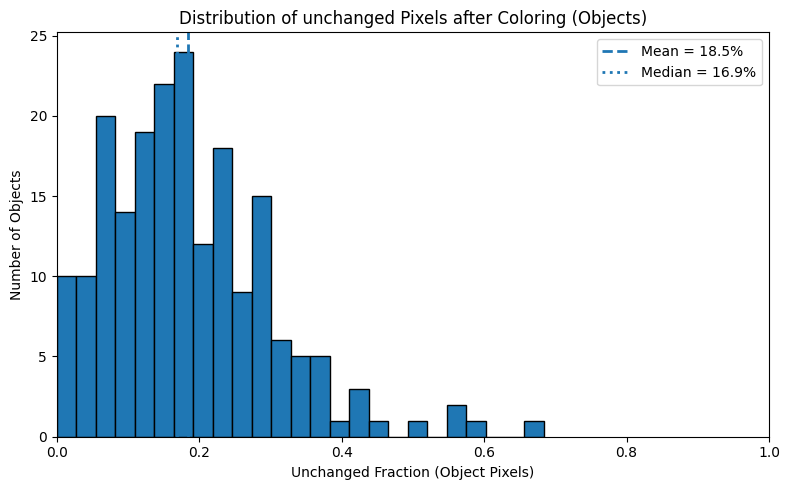

In [36]:
vals = df_compare["actual_change_fraction"].dropna()
unchanged = 1 - vals

mean_val = unchanged.mean()
median_val = unchanged.median()

plt.figure(figsize=(8, 5))

plt.hist(unchanged, bins=25, edgecolor="black")

plt.axvline(mean_val, linestyle="--", linewidth=2,
            label=f"Mean = {mean_val:.1%}")
plt.axvline(median_val, linestyle=":", linewidth=2,
            label=f"Median = {median_val:.1%}")

plt.xlabel("Unchanged Fraction (Object Pixels)")
plt.ylabel("Number of Objects")
plt.title("Distribution of unchanged Pixels after Coloring (Objects)")

plt.xlim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

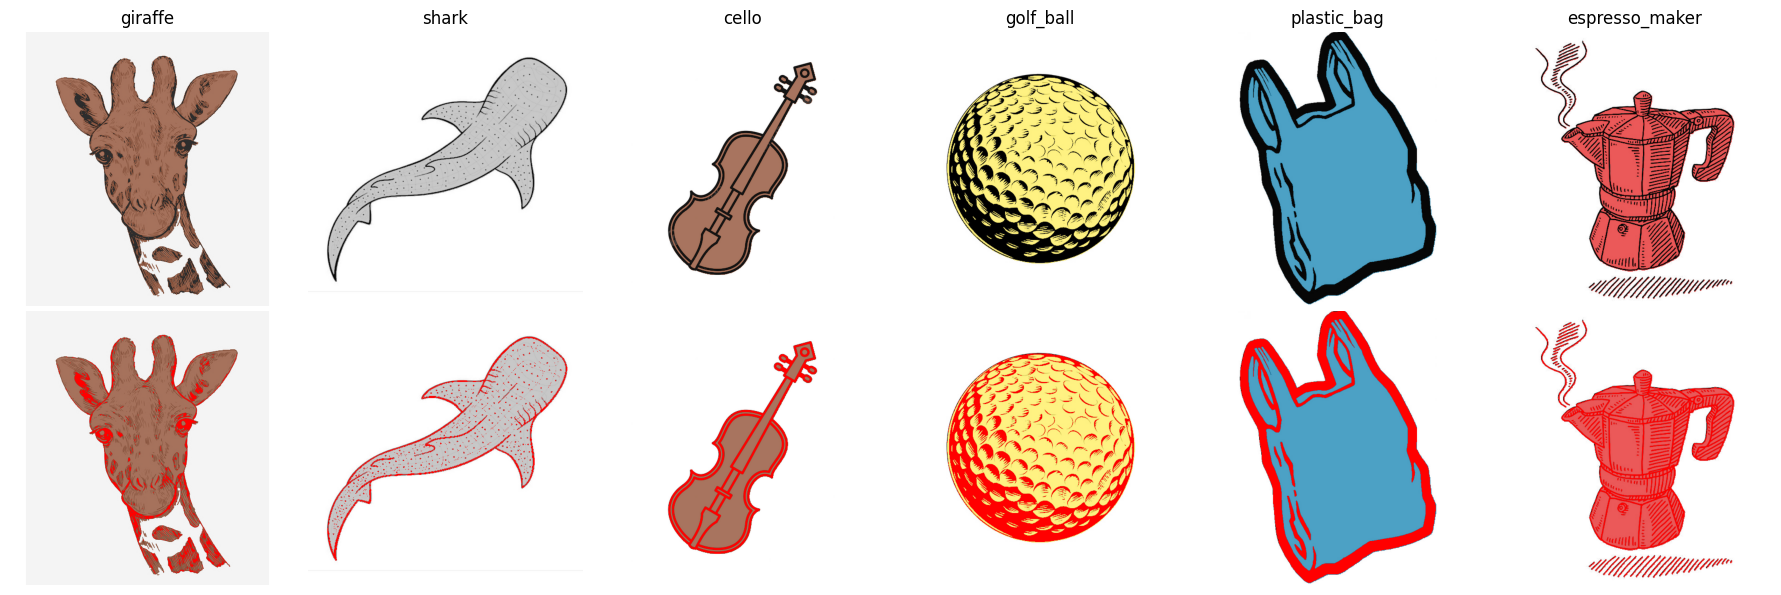

In [38]:
def plot_unchanged_examples(df, root, n=6):

    sample_df = df.sample(n)

    fig, axes = plt.subplots(2, n, figsize=(3*n, 6))

    for i, (_, row) in enumerate(sample_df.iterrows()):

        img_0 = np.array(
            Image.open(root / row["image_path_0"]).convert("RGB")
        )

        img_100 = np.array(
            Image.open(root / row["image_path_100"]).convert("RGB")
        )

        H, W, _ = img_0.shape

        mask = Image.open(root / row["cv_mask_path"]).convert("L")
        mask = mask.resize((W, H), Image.NEAREST)
        mask = np.array(mask) > 127

        diff = np.any(img_0 != img_100, axis=2)

        # Unchanged pixels inside object
        unchanged = (~diff) & mask

        overlay = img_100.copy()

        # Color unchanged pixels red
        overlay[unchanged] = [255, 0, 0]

        axes[0, i].imshow(img_100)
        axes[0, i].set_title(row["object"])
        axes[0, i].axis("off")

        axes[1, i].imshow(overlay)
        axes[1, i].axis("off")

    axes[0, 0].set_ylabel("FG 100%", fontsize=12)
    axes[1, 0].set_ylabel("Unchanged in Red", fontsize=12)

    plt.tight_layout()
    plt.show()

plot_unchanged_examples(df_compare, DATA)

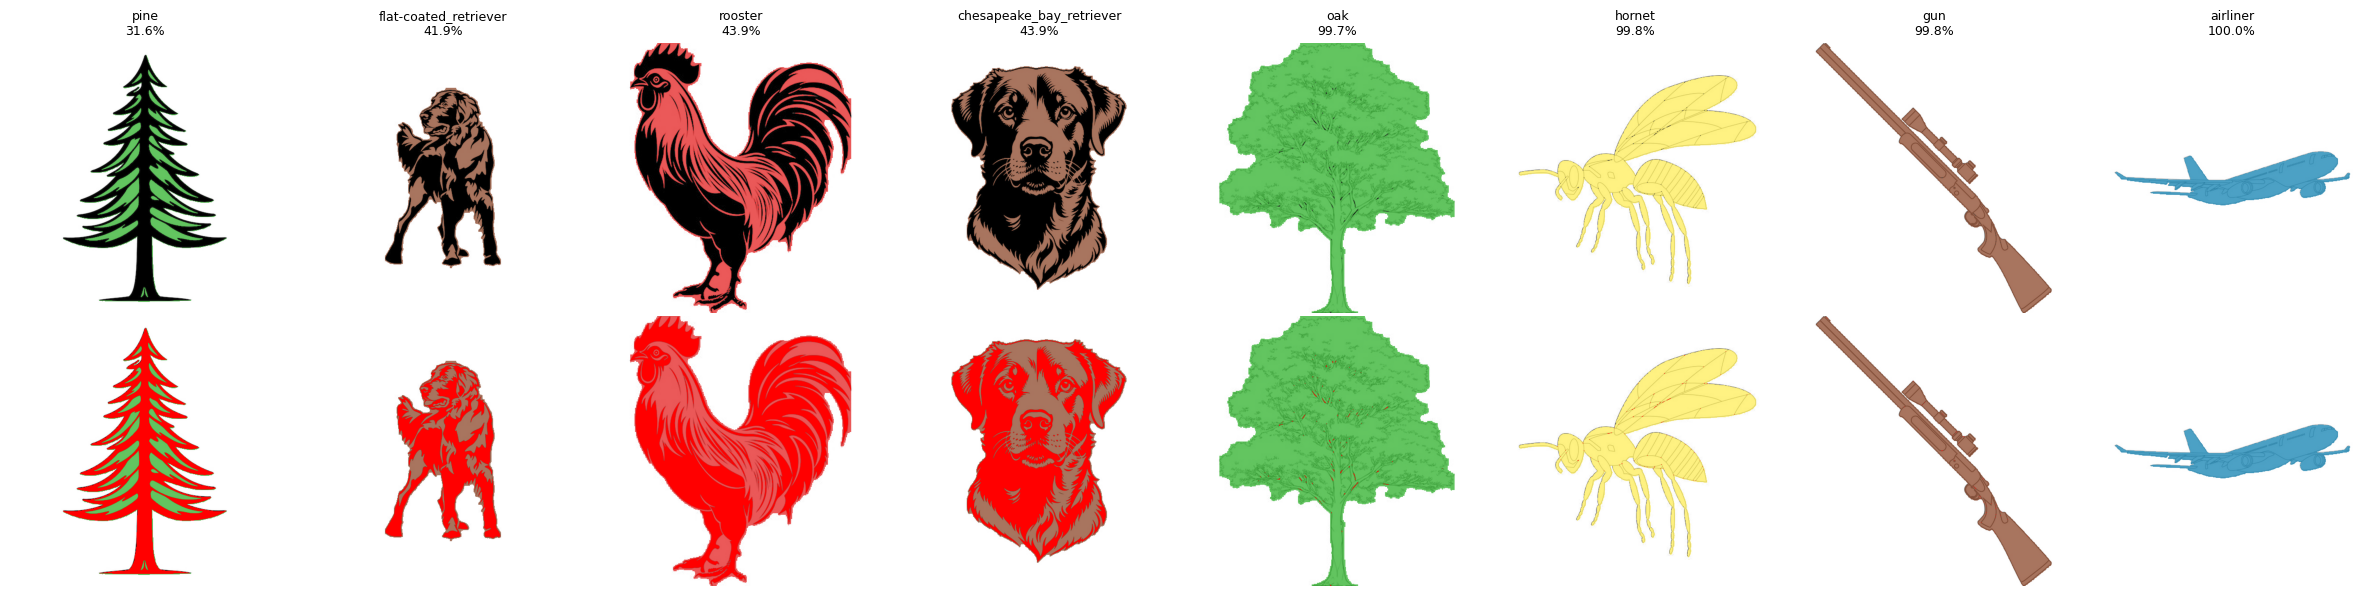

In [40]:
def plot_recoloring(df, root, n=4):

    df = df.dropna(subset=["actual_change_fraction"])

    # Sort by recoloring strength
    df_sorted = df.sort_values("actual_change_fraction")

    bottom_df = df_sorted.head(n)      # least recolored
    top_df = df_sorted.tail(n)        # most recolored

    combined = list(bottom_df.iterrows()) + list(top_df.iterrows())

    fig, axes = plt.subplots(2, 2*n, figsize=(3*2*n, 6))

    for i, (_, row) in enumerate(combined):

        img_0 = np.array(
            Image.open(root / row["image_path_0"]).convert("RGB")
        )

        img_100 = np.array(
            Image.open(root / row["image_path_100"]).convert("RGB")
        )

        H, W, _ = img_0.shape

        mask = Image.open(root / row["cv_mask_path"]).convert("L")
        mask = mask.resize((W, H), Image.NEAREST)
        mask = np.array(mask) > 127

        diff = np.any(img_0 != img_100, axis=2)
        unchanged = (~diff) & mask

        overlay = img_100.copy()
        overlay[unchanged] = [255, 0, 0]

        title = f"{row['object']}\n{row['actual_change_fraction']:.1%}"

        axes[0, i].imshow(img_100)
        axes[0, i].set_title(title, fontsize=9)
        axes[0, i].axis("off")

        axes[1, i].imshow(overlay)
        axes[1, i].axis("off")

    axes[0, 0].set_ylabel("FG 100%", fontsize=12)
    axes[1, 0].set_ylabel("Unchanged in Red", fontsize=12)

    plt.tight_layout()
    plt.show()

plot_recoloring(df_compare, DATA)